# Prueba Data Science


### Datos
DATA DESCRIPTION:

•	policy_desc: Policy Identifier; Primary Key which is unique for every policy

•	claim_count: Total Claims (This is the response you should predicting); Numeric Variable

•	cat_areacode: Area Code; Categorical Variable

•	num_vehicleAge: Age of the vehicle; Numeric Variable

•	num_noClaimDiscountPercent: Percentage of discount applied to policy premium based on claim history. If value is greater than 100 then policy premium was increased, if it’s less than 100 a discount was applied. A value of 100 means the premium remain unchanged; Numerical Variable

•	cat_carBrand: Insured Vehicle Brand; Categorical Variable

•	num_populationDensitykmsq: Population density of the city the policy holder lives in; Numerical Variable

•	cat_Region; Region of the country the policy holder lives in; Categorical Variable

•	ord_vehicleHP: Vehicle Horsepower; This feature is anonymised but maintains the same ordinality; Ordinal Variable

•	num_exposure: Exposure time of policy. Time period within which the claims were made; Numerical Variable

•	cat_fuelType: Insured Vehicle Fuel Type; Categorical Variable

•	num_driverAge: Age of the Policy Holder; Numerical Variable




El problema planteado es entender la frecuencia de claims para cada poliza, por esta razon la idea seria usando las otras variables poder predecir el numero de claims dadas variables del vehiculo, zona de circulacion, y edad del cliente para poder determinar dadas estas variables cuantos claims podriamos esperar 

Primero importo librerias utiles aunque no las use todas

In [1]:

#Python
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt

#Regressor Models
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.linear_model import LinearRegression

#Classifier Models
from sklearn.ensemble import RandomForestClassifier


# data processing
from sklearn import metrics
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE


# transforms
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

# sklearn
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.feature_selection import RFE
from sklearn.preprocessing import OneHotEncoder, power_transform, LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import classification_report
from sklearn.ensemble import StackingRegressor

#Otros
import optuna
import pickle

# typing
from typing import List, Dict, Tuple, Union, Generator, Optional, Any






Este codigo es util para poder realizar revision de resultados de lo que vaya haciendo como se podra ver mas adelante

In [2]:
# utils
def performance_regression_model(
        y_true: np.array, 
        y_pred: np.array,
        view_plot: bool=True,
        view_stats: bool=True
    )->Dict:
    """"""

    model_score: Dict = dict(
        r2=r2_score(y_true, y_pred),
        rmse=mean_squared_error(y_true, y_pred, squared=False),
        mse=mean_squared_error(y_true, y_pred),
        mae=mean_absolute_error(y_true, y_pred)
    )

    if view_plot:
        pd.DataFrame({
            'predictions':y_pred,
            'residuals':y_true - y_pred         
        }).plot(
            x='predictions', y='residuals', kind='scatter',
            c='black', s=10, alpha=0.1
        )

    if view_stats:
        print('r2:', model_score.get('r2'))
        print('RMSE:', model_score.get('rmse'))
        print('mse:', model_score.get('mse'))
        print('mae:', model_score.get('mse'))
    
    return model_score

In [3]:
dataTraining = pd.read_csv('casestudy_data.csv')

C:\Users\WD\AppData\Local\Temp\ipykernel_22148\1013168171.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  dataTraining = pd.read_csv('casestudy_data.csv')


Revision de datos inicial, se puede ver algunas variables categoricas y numericas, que mas adelante se entrara mas a detaller

In [4]:
dataTraining.head()

,policy_desc,claim_count,cat_areacode,num_vehicleAge,num_noClaimDiscountPercent,cat_carBrand,num_populationDensitykmsq,cat_Region,ord_vehicleHP,num_exposure,cat_fuelType,num_driverAge
0,1,1,D,0,50,B12,1217,R82,5,0.1,Regular,55
1,3,1,D,0,50,B12,1217,R82,5,0.77,Regular,55
2,5,1,B,2,50,B12,54,R22,6,0.75,Diesel,52
3,10,1,B,0,50,B12,76,R72,7,0.09,Diesel,46
4,11,1,B,0,50,B12,76,R72,7,0.84,Diesel,46


Elimino Policy_Desc porque no hay ningun valor repetido y todas son polizas unicas en los datos

In [5]:
dataTraining.drop(['policy_desc'],axis=1,inplace=True)

In [6]:
dataTraining['claim_count'].value_counts()

claim_count
0     643953
1      32178
2       1784
3         82
4          7
11         3
5          2
6          1
8          1
16         1
9          1
Name: count, dtype: int64

Una vez que se observo esto fue posible darse cuenta que iba a haber un problema de desbalanceo.

El desbalanceo es importante porque al intentar predecir la variable si se tienen mas datos de una clase en este caso 0 claims, es esperable que el modelo prediga mayor la probabilidad de tener 0 claims pues se encuentran muchos mas en la base

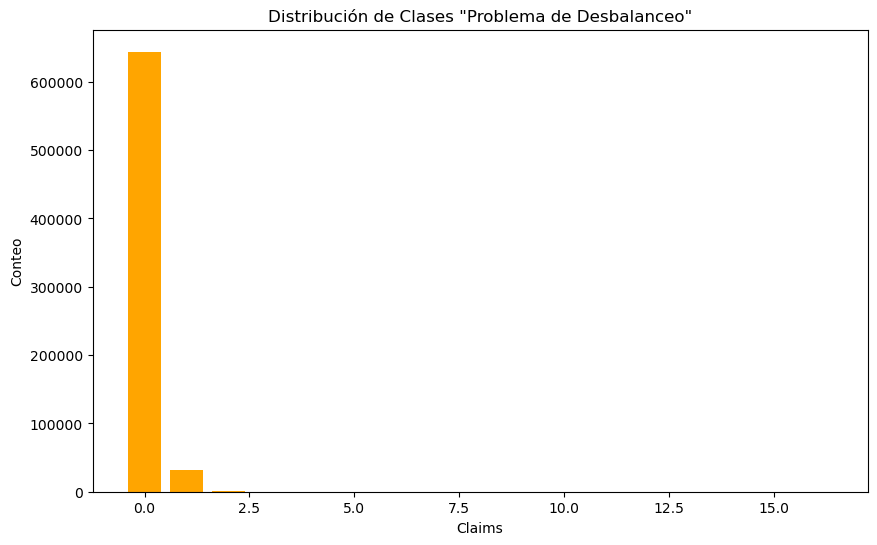

In [7]:
conteo = {
    0: 643919,
    1: 32176,
    2: 1784,
    3: 82,
    4: 7,
    11: 3,
    5: 2,
    6: 1,
    8: 1,
    16: 1,
    9: 1
}

clases = list(conteo.keys())
frecuencias = list(conteo.values())

plt.figure(figsize=(10, 6))
plt.bar(clases, frecuencias, color='orange')

plt.xlabel('Claims')
plt.ylabel('Conteo')
plt.title('Distribución de Clases "Problema de Desbalanceo"')

plt.show()

#### Eliminacion valores vacios (asi venian inicialmente)

cat_fuelType                  22


num_driverAge                 14

In [8]:
dataTraining.dropna(inplace=True)
dataTraining.isnull().sum()

claim_count                   0
cat_areacode                  0
num_vehicleAge                0
num_noClaimDiscountPercent    0
cat_carBrand                  0
num_populationDensitykmsq     0
cat_Region                    0
ord_vehicleHP                 0
num_exposure                  0
cat_fuelType                  0
num_driverAge                 0
dtype: int64

En los datos se puede ver que toma num_exposure y num_driverAge como objects pero son float e int, la razon es valores raros como 10years, 23years, etc. 
En este caso solo se convertira en numeric y cualquier otro valor convertira en NaN es decir vacio

In [9]:
dataTraining.dtypes

claim_count                    int64
cat_areacode                  object
num_vehicleAge                 int64
num_noClaimDiscountPercent     int64
cat_carBrand                  object
num_populationDensitykmsq      int64
cat_Region                    object
ord_vehicleHP                  int64
num_exposure                  object
cat_fuelType                  object
num_driverAge                 object
dtype: object

In [10]:
#print(dataTraining['num_exposure'].unique())
#print(dataTraining['num_driverAge'].unique())
dataTraining['num_exposure'] = pd.to_numeric(dataTraining['num_exposure'], errors='coerce')

dataTraining['num_driverAge'] = pd.to_numeric(dataTraining['num_driverAge'], errors='coerce')
dataTraining.dtypes

claim_count                     int64
cat_areacode                   object
num_vehicleAge                  int64
num_noClaimDiscountPercent      int64
cat_carBrand                   object
num_populationDensitykmsq       int64
cat_Region                     object
ord_vehicleHP                   int64
num_exposure                  float64
cat_fuelType                   object
num_driverAge                 float64
dtype: object

# Regresion

Inicialmente se trabaja el problema como regresion para determinar la cantidad de claims

## Definicion Pipeline datos

Se define un pipeline para la transformacion de variables numericas y categoricas. Para las numericas se utiliza StandardScaler y Power Transformer y para las categoricas se utiliza One-Hot Encoder.


Power Transformer puede ayudar a normalizar la distribución de los datos mientras que Standard Scaler estandariza las características eliminando la media y escalando a la varianza unitaria

OneHot Encoder se usa para convertir variables categoricas en binarias lo que puede ayudar al momento de usar diferentes algoritmos

In [11]:
# Identificación de columnas
num_cols = [col for col in dataTraining.select_dtypes(include='int64').columns if col != 'claim_count']
cat_cols = dataTraining.select_dtypes(include='object').columns.tolist()
target_col = 'claim_count' if 'claim_count' in dataTraining.columns else None

# Separación de datos en X e y
X = pd.concat([dataTraining[num_cols], dataTraining[cat_cols].astype('category')], axis=1)
y = dataTraining[target_col].astype('category')

# preprocesamiento
numeric_pipe = make_pipeline(StandardScaler(),PowerTransformer())
categorical_pipe = make_pipeline(OneHotEncoder(handle_unknown='ignore'))
preprocessor = make_column_transformer(
    (numeric_pipe, num_cols),
    (categorical_pipe, cat_cols)
)

# canalizacion
transformation_pipe = make_pipeline(preprocessor)
transformation_pipe.fit(X)

X_transformed = transformation_pipe.transform(X)


In [12]:
transformation_pipe 

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('powertransformer',
                                                                   PowerTransformer())]),
                                                  ['num_vehicleAge',
                                                   'num_noClaimDiscountPercent',
                                                   'num_populationDensitykmsq',
                                                   'ord_vehicleHP']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['cat_areacode',
                                                   'cat_carBrand', 'cat_Region',
                                                   'cat_fuelType'])]))])

## Resampleo

Inicialmente el problema que se tiene es que el 94% de las observaciones son de la clase 0 y como se menciono antes esto supone un problema en la creacion de modelos

Class=1, n=32176 (4.746%)
Class=2, n=1784 (0.263%)
Class=4, n=7 (0.001%)
Class=3, n=82 (0.012%)
Class=9, n=3 (0.000%)
Class=0, n=643919 (94.977%)
Class=5, n=2 (0.000%)
Class=6, n=1 (0.000%)
Class=7, n=1 (0.000%)
Class=10, n=1 (0.000%)
Class=8, n=1 (0.000%)


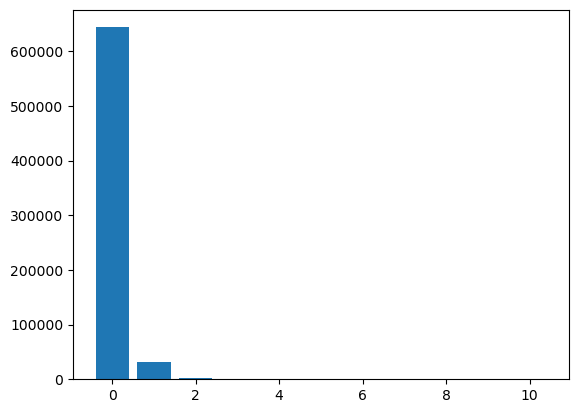

In [ ]:
from collections import Counter
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
 per = v / len(y) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

Resampleo en todas las clases

Class=1, n=643919 (9.091%)
Class=2, n=643919 (9.091%)
Class=4, n=643919 (9.091%)
Class=3, n=643919 (9.091%)
Class=9, n=643919 (9.091%)
Class=0, n=643919 (9.091%)
Class=5, n=643919 (9.091%)
Class=6, n=643919 (9.091%)
Class=7, n=643919 (9.091%)
Class=10, n=643919 (9.091%)
Class=8, n=643919 (9.091%)


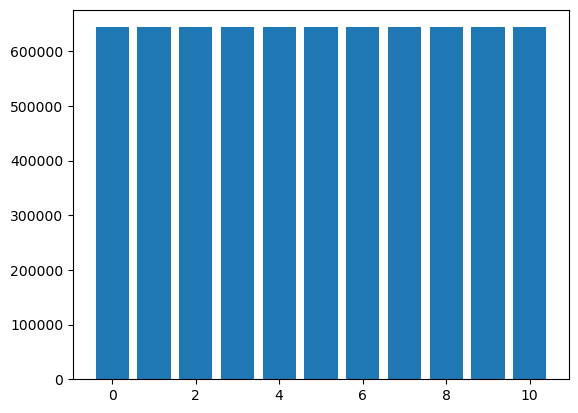

In [15]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

y = LabelEncoder().fit_transform(y)

# Crear el sobremuestreador
oversample = RandomOverSampler()
X_resampled, y_resampled = oversample.fit_resample(X_transformed, y)

# Resumen de la distribución de clases
counter = Counter(y_resampled)
for k, v in counter.items():
    per = v / len(y_resampled) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

# Graficar la distribución
plt.bar(counter.keys(), counter.values())
plt.show()

De ahora en adelante los datos de entrenamiento y prueba seran los que fueron resampleados

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

## Modelos

### XGBoost

Se puede ver un R2 de 0.89 es decir que explica el 89% de la variable objetivo con el actual modelo. Sin embargo al revisar el grafico de predicciones versus residuos se puede ver que estos no se comportan aleatyorios al rededor del 0. Lo que puede significar  un problema 

c:\Users\WD\.conda\envs\VSCEnv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


r2: 0.873673547380727
RMSE: 1.1241118137139992
mse: 1.2636273697313767
mae: 1.2636273697313767


{'r2': 0.873673547380727,
 'rmse': 1.1241118137139992,
 'mse': 1.2636273697313767,
 'mae': 0.7447720162101386}

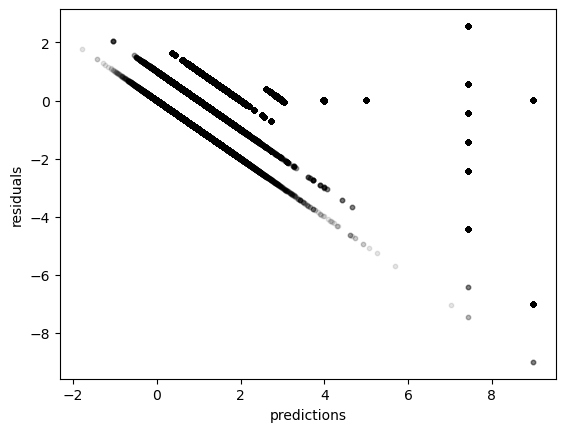

In [18]:
XGBRegPipe = XGBRegressor()
XGBRegPipe.fit(X_train, y_train)

ypred=XGBRegPipe.predict(X_test)
RMSENotScaledSVM=mean_squared_error(y_test, ypred)


performance_regression_model(y_test.ravel(), ypred)

Optimizacion de hiperparametros modelo XGBoost

In [19]:
def objective(trial):
    # Definición de los hiperparámetros a optimizar
    param = {
        'objective': 'reg:squarederror',
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0)
    }
    

    model = XGBRegressor(**param, enable_categorical=True)

    # Entrenamiento del modelo
    model.fit(X_train_transformed, y_train)

    # Realización de predicciones en el conjunto de prueba
    y_pred = model.predict(X_test_transformed)

    # Cálculo de la métrica de evaluación (error cuadrático medio)
    mse = mean_squared_error(y_test, y_pred)

    return mse

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2024-08-01 09:23:37,364] A new study created in memory with name: no-name-4da1965f-03a8-4ce5-bba3-fc28f31117b6
[I 2024-08-01 09:23:38,485] Trial 0 finished with value: 0.04371361504908737 and parameters: {'max_depth': 9, 'learning_rate': 0.2144146646561897, 'n_estimators': 121, 'subsample': 0.9846128479067022, 'colsample_bytree': 0.922409115452502, 'min_child_weight': 6, 'gamma': 0.8507544127120458}. Best is trial 0 with value: 0.04371361504908737.
[I 2024-08-01 09:23:40,578] Trial 1 finished with value: 0.04369415001672142 and parameters: {'max_depth': 10, 'learning_rate': 0.10325173659915517, 'n_estimators': 265, 'subsample': 0.8078320116675579, 'colsample_bytree': 0.84180857028226, 'min_child_weight': 6, 'gamma': 0.6209571198621009}. Best is trial 1 with value: 0.04369415001672142.
[I 2024-08-01 09:23:42,450] Trial 2 finished with value: 0.04386465403009727 and parameters: {'max_depth': 8, 'learning_rate': 0.2516656898641312, 'n_estimators': 275, 'subsample': 0.5621481468194218, 

In [ ]:
print('Best parameters', study.best_params)

Best parameters {'max_depth': 10, 'learning_rate': 0.02526721602824744, 'n_estimators': 220, 'subsample': 0.9027010910475677, 'colsample_bytree': 0.6340801908849835, 'min_child_weight': 3, 'gamma': 0.07750413308001167}


Se guardan los hiperparametros de XGBoost para ser usados despues pues al ofrecer un buen resultado de por si al stackearlo con otros modelos podrias mejorar

In [ ]:
paramsxg1 = {
    'objective': 'reg:squarederror',  # Objetivo de regresión con error cuadrado
    'max_depth': 10,                   # Profundidad máxima de los árboles
    'learning_rate': 0.02405465164605032,             # Tasa de aprendizaje
    'n_estimators': 180,              # Número de árboles a construir
    'subsample':  0.5628425093858869,                 # Submuestra de datos para el entrenamiento de cada árbol
    'colsample_bytree': 0.9771032389526358,          # Submuestra de características para el entrenamiento de cada árbol
    'min_child_weight': 9,
    'gamma':0.09999149057168405
}

El optimizar los hiperparametros del modelo supone una pequeña mejoria en el modelo 

In [ ]:
XGBReg1_Optuna = XGBRegressor(enable_categorical=True,**paramsxg1)

XGBReg1_Optuna.fit(X_train,y_train)

y_pred = XGBReg1_Optuna.predict(X_test)
performance_regression_model(y_test.ravel(), y_pred)

Despues de la calibracion por optuna y posteriormente la calibracion manual, este es el mejor resultado obtenido, a continuacion se explicara que implica cada parametro:

objective: especifica la función de pérdida que se va a minimizar durante el entrenamiento. En este caso, 'reg:squarederror' indica que se trata de una tarea de regresión con el error cuadrático como la métrica de pérdida, lo anterior significa que el modelo intentará minimizar la diferencia cuadrada entre las predicciones y los valores reales.

max_depth: este parámetro define la profundidad máxima de los árboles que se construirán, limitar la profundidad del árbol ayuda a prevenir el sobreajuste, arboles más profundos permiten al modelo aprender relaciones más complejas, pero también pueden capturar ruido en los datos.


learning_rate: también conocido como tasa de aprendizaje o "eta", controla la contribución de cada arbol al modelo final, un valor bajo hace que el modelo sea más robusto a la estructura específica del árbol, reduciendo el riesgo de sobreajuste, pero requiere más árboles (n_estimators) para ser efectivo.

n_estimators: es el número de arboles que se construirán en el modelo, más árboles pueden hacer que el modelo sea más potente, pero también más lento para entrenar y más susceptible al sobreajuste si la tasa de aprendizaje no está bien ajustada.

subsample: es la fracción de muestras utilizadas para entrenar cada árbol, si es menor que 1.0, entonces XGBoost utilizará un muestreo aleatorio de los datos, lo que puede ayudar a hacer que el modelo sea más robusto al sobreajuste.

colsample_bytree: este parámetro controla la fracción de características (columnas) que se utilizarán para cada árbol, un valor menor que 1.0 significa que cada árbol usará una fracción aleatoria de las características, esto es útil para aumentar la diversidad de los árboles y, por tanto, mejorar el rendimiento del modelo.

min_child_weight: es un parámetro que controla el umbral mínimo de suma de pesos de instancias necesarias en un nodo hijo, este se usa para controlar el sobreajuste, valores más altos evitan que el modelo aprenda relaciones demasiado específicas, favoreciendo estructuras de árbol más simples.

gamma:  es el parámetro de poda mínima de pérdida, gamma especifica la reducción mínima en la pérdida requerida para hacer una partición adicional en un nodo del árbol, un valor más alto hace que el algoritmo sea más conservador, resultando en árboles más simples y menos complejos.

### Random Forest

La utilidad de random forest radica en que funciona como una union de muchos arboles de decision que funciona de manera mas robusta. Al construir múltiples árboles de decisión y promediar sus resultados, random forests tienden a ser menos susceptibles al sobreajuste (overfitting) que un solo árbol de decisión

Alta precisión en comparación con otros algoritmos de aprendizaje automático debido a su capacidad para manejar grandes conjuntos de datos y una variedad de características.

El unico problema es su tiempo de corrida, en este caso tomo 88 minutos

In [20]:
# crear el modelo Random Forest Regressor
rf_regressor = RandomForestRegressor(random_state=42, n_jobs=-1)

#  entrenamiento
rf_regressor.fit(X_train, y_train)

# hacer predicciones con los datos de prueba
y_pred_rf = rf_regressor.predict(X_test)


r2: 0.8864075685223176
RMSE: 1.065950553629399
mse: 1.136250582782822
mae: 1.136250582782822


c:\Users\WD\.conda\envs\VSCEnv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'r2': 0.8864075685223176,
 'rmse': 1.065950553629399,
 'mse': 1.136250582782822,
 'mae': 0.5890229063360211}

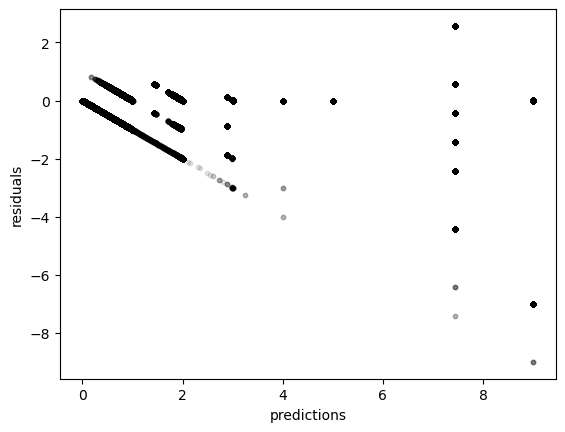

In [22]:
performance_regression_model(y_test.ravel(), y_pred_rf)

### Stacking

Se stackean los dos modelos que dieron un buen resultado y un CV de 3 por temas de tiempo aunque se utilizaria un CV de 5.

CV quiere decir cross validation, este consiste en tomar el conjunto de datos se divide en varias partes o "folds".  El modelo se entrena en un subconjunto de los datos (por ejemplo, 9 de los 10 pliegues) y se evalúa en el pliegue restante (el pliegue no utilizado para el entrenamiento). Este proceso se repite varias veces, cada vez con un pliegue diferente como conjunto de prueba y los otros pliegues como conjunto de entrenamiento.

En este caso un CV de 3 quiere decir que se entrenara el modelo 3 veces y esas mismas 3 veces se probara su resultado para después realizar la evaluación en cada pliegue, se calculan y promedian las métricas de rendimiento y ese seria el resultado de este modelo final. 

In [23]:
estimators = [
    ('xgb', XGBRegressor(
        n_estimators=180,
        max_depth=10,
        learning_rate=0.02405465164605032,
        subsample=0.5628425093858869,
        colsample_bytree=0.9771032389526358,
        min_child_weight=9,
        gamma=0.09999149057168405,
        random_state=42,
        n_jobs=-1
    )),
     ('rf', RandomForestRegressor(
         random_state=42,
         n_jobs=-1
    ))

]



# definir el meta-modelo
final_estimator = LinearRegression()

# crear el modelo de stacking
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=final_estimator,
    cv=3
)

# entrenar el modelo de stacking
stacking_model.fit(X_train, y_train)

# Hacer predicciones con el modelo de stacking
y_pred_stack = stacking_model.predict(X_test)


KeyboardInterrupt: 

Por temas de tiempo no fue posible correr el modelo sampleado completo ni mostrar resultados, pero al hacer uso de el stacking para ensamblar dos modelos para usar un meta modelo de regresion lineal final que toma en cuenta los resultados de ambos modelos suele presentar mejores resultados.


El modelo de ensamble suele proporcionar el mejor rendimiento general al combinar las predicciones de múltiples modelos, lo que lleva a un mejor ajuste y una generalización más fuerte. Se suele observar mayor eficacia al combinar modelos con diferentes fortalezas y patrones de aprendizaje, lo que a menudo puede producir un modelo compuesto que es superior a cualquiera de sus componentes individuales.


Lastimosamente el tiempo que toma poder ensamblar estos modelos es mas alto, lo que ocasiono que en esta ocasion no se tuviera el resultado.



Sin embargo aunque tuviera mejor resultado podria haber sido dificil ofrecer interpretabilidad con este modelo

# Clasificacion

Ademas de esto tambien se intento resolver el problema por medio de un modelo de clasificacion que inicialmente tambien presentaba problemas por desbalanceo

Haciendo pruebas antes de usar resampleo se encontro lo siguiente usando classification_report, lo cual era esperado, cuando se tienen 0 claims la precision es 0.95.

Los resultados en el caso de clasificacion se miden como se ve a continuacion:

Es decir verdaderos positivos (TP), falsos positivos (FP), Falsos Negativos (FN)  y verdaderos neegativos (TN)


#### Precision
Es la proporción de predicciones positivas correctas (positivos verdaderos) entre todas las predicciones positivas realizadas por el modelo
$$Precision=\frac{TP}{TP+FP}=\frac{Aciertos positivos}{Asignaciones positivas}$$

#### Accuracy

 Es la proporción de predicciones correctas (tanto positivas como negativas) realizadas por el modelo sobre el total de predicciones realizadas.

$$Accuracy=\frac{TP+TN}{TP+TN+FN+FP}=\frac{Aciertos}{n}$$

##### Error
$$Error=1-{Accuracy}$$

                  precision    recall  f1-score   support

           0       0.95      0.99      0.97    212576
           1       0.25      0.09      0.13     10539
           2       0.02      0.01      0.01       587
           3       0.00      0.00      0.00        26
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         1


    accuracy                           0.94    223733


   macro avg       0.14        0.12        0.12       223733


weighted avg       0.92       0.94         0.93     223733



Con este modelo de random forest classifier se encuentra nuevamente un modelo random forest que podria llegar a ser muy robusto pero nuevamente es mas demorado de correr y tiene una interpretabilidad limitada. 

In [29]:
#Modelo con balanceo de muestras
model=RandomForestClassifier(n_estimators=100, random_state=0, class_weight='balanced')

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

KeyboardInterrupt: 

In [25]:
#Prueba de modelo sin balanceo de clases

from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd



num_cols = [col for col in dataTraining.select_dtypes(include='int64').columns if col != 'claim_count']
cat_cols = dataTraining.select_dtypes(include='object').columns.tolist()
target_col = 'claim_count' if 'claim_count' in dataTraining.columns else None


X = pd.concat([dataTraining[num_cols], dataTraining[cat_cols].astype('category')], axis=1)
y = dataTraining[target_col]

# Preprocesamiento
numeric_pipe = make_pipeline(StandardScaler())
categorical_pipe = make_pipeline(OneHotEncoder(handle_unknown='ignore'))
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipe, num_cols),
        ('cat', categorical_pipe, cat_cols)
    ]
)


model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=0, class_weight='balanced'))
])

# División de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

# Entrenamiento y evaluación
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

KeyboardInterrupt: 

Finalmente se presento realmente 2 modelos de regresion con balanceo de clases XGBoost y Random Forest, el resultado de estos fue:

XGBoost:
{'r2': 0.873673547380727,
 'rmse': 1.1241118137139992}

Random Forest:
{'r2': 0.8864075685223176,
 'rmse': 1.065950553629399}


 
MSE proporciona una medida de la magnitud del error en las mismas unidades que la variable de interés, en este caso, el numero de claims, para XGBoost es 1.26 claims de desviacion y Random Forest 1.136. 

Un R² cercano a 1 indica que el modelo puede explicar muy bien la variabilidad de los precios de los vehículos basado en las características, en este caso el mejor modelo  (Random Forest) 0,886 que es cercano a 1, y se considera bueno (con posibilidad de mejorar)

Sin embargo habria que seguir revisando el problema de las predicciones vs residuales pues se puede ver no estan aleatoriamente distribuidos. Esto puede pasar por muchas razones como Multicolinealidad o un error en la trasnformacion de datos.
